In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import matplotlib.pyplot as plt

#from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [56]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'UT'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill2/'

In [31]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/'
# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [32]:
gdf = gpd.read_file(outpath+'CSO_SNOTEL_sites.geojson')
df = pd.read_csv(outpath+'CSO_SNOTEL_data_SWEDmeters.csv') 
gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,366_UT_SNTL,-111.581673,40.599361,Brighton,2671.876708984375,450785.292592,4.494447e+06,POINT (-111.58167 40.59936)
1,628_UT_SNTL,-111.636833,40.658829,Mill-D North,2731.92236328125,446165.968230,4.501080e+06,POINT (-111.63683 40.65883)
2,766_UT_SNTL,-111.654999,40.563999,Snowbird,2931.26171875,444552.015595,4.490565e+06,POINT (-111.65500 40.56400)
3,814_UT_SNTL,-111.533218,40.623501,Thaynes Canyon,2813.303955078125,454901.209970,4.497100e+06,POINT (-111.53322 40.62350)


In [37]:
# calibration_2020-05-24_full_set.nc the MAE metric is actually r**2
data = xr.open_dataset(outpath+'calibration_2020-07-06_full_set.nc')
data

<xarray.Dataset>
Dimensions:          (calibration_run: 10752, metric: 5, station: 4)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 ... 10748 10749 10750 10751
  * metric           (metric) object 'MAE' 'MBE' 'RMSE' 'NSE' 'KGE'
  * station          (station) object '366_UT_SNTL' ... '814_UT_SNTL'
Data variables:
    cal_metrics      (calibration_run, metric, station) float64 ...
Attributes:
    description:             SnowModel line calibration performance metrics
    calibration_parameters:  ro_snowmax,cf_precip_scalar,ro_adjust
    model_parameter:         SWE [m]

In [38]:
#'cal_params_2020-07-03_full_set.csv'
calibration = pd.read_csv(outpath+'cal_params_2020-07-06_full_set.csv')
calibration.head()

,lat_solar_flag,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust,gap_frac
0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.0
1,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.2
2,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.4
3,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.6
4,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,5.0,0.0


# Find average top performing metrics 
For a given OF, take the average skill score across all stations

In [39]:
NSE = data.cal_metrics.loc[:,"NSE",:]
nse_top = np.amax(data.cal_metrics.loc[:,"NSE",:],axis = 0)
KGE = data.cal_metrics.loc[:,"KGE",:]
kge_top = np.amax(data.cal_metrics.loc[:,"KGE",:],axis = 0)
RMSE = data.cal_metrics.loc[:,"RMSE",:]
rmse_top = np.amin(data.cal_metrics.loc[:,"RMSE",:],axis = 0)
R_2 = data.cal_metrics.loc[:,"MAE",:]
r2_top = np.amax(data.cal_metrics.loc[:,"MAE",:],axis = 0)
MBE = data.cal_metrics.loc[:,"MBE",:]
mbe_top = np.amin(data.cal_metrics.loc[:,"MBE",:],axis = 0)

print('maxNSE:', r2_top)

maxNSE: <xarray.DataArray 'cal_metrics' (station: 4)>
array([0.8442612 , 0.74795676, 0.55932172, 0.61866429])
Coordinates:
    metric   <U3 'MAE'
  * station  (station) object '366_UT_SNTL' '628_UT_SNTL' ... '814_UT_SNTL'


Text(0.5, 1.0, 'R**2')

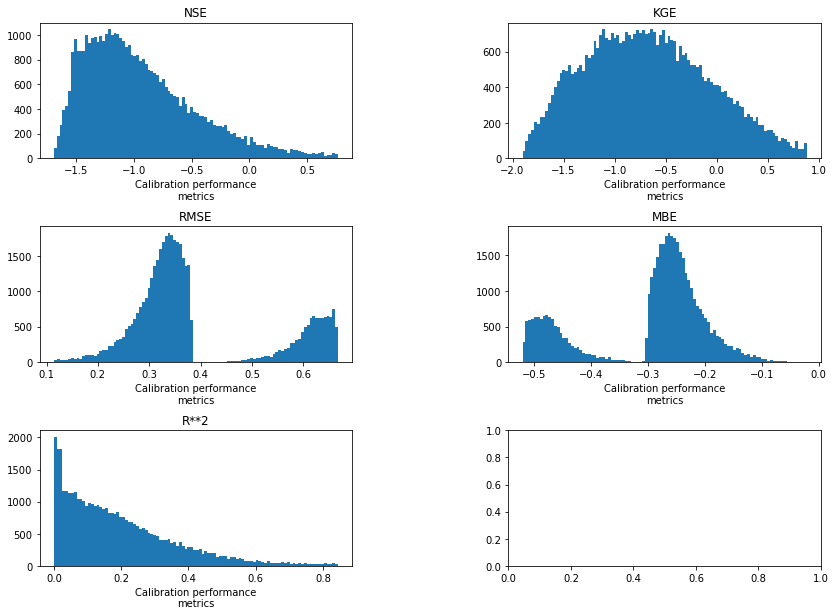

In [40]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
NSE.plot.hist(ax=axes[0,0],bins=100)
axes[0,0].set_title('NSE')
KGE.plot.hist(ax=axes[0,1],bins=100)
axes[0,1].set_title('KGE')
RMSE.plot.hist(ax=axes[1,0],bins=100)
axes[1,0].set_title('RMSE')
MBE.plot.hist(ax=axes[1,1],bins=100)
axes[1,1].set_title('MBE')
R_2.plot.hist(ax=axes[2,0],bins=100)
axes[2,0].set_title('R**2')

In [41]:
#fig.savefig(figpath+'domain_cal_metrics.pdf', format='pdf', dpi=300)

### Data frame of metrics averaged over domain for each model run

In [42]:
x = np.empty((len(calibration),5))
x[:,0] = np.mean(NSE.values,axis=1)
x[:,1] = np.mean(KGE,axis=1).values
x[:,2] = np.mean(RMSE,axis=1).values
x[:,3] = np.mean(R_2,axis=1).values
x[:,4] = np.mean(MBE,axis=1).values

dataav = pd.DataFrame(x,columns=['NSE', 'KGE', 'RMSE','R_2','MBE'])
dataav
#dataav.to_csv('calibration_params.csv')

,NSE,KGE,RMSE,R_2,MBE
0,-1.464497,-1.420413,0.440238,0.026080,-0.341565
1,-1.464497,-1.420413,0.440238,0.026080,-0.341565
2,-1.464497,-1.420413,0.440238,0.026080,-0.341565
3,-1.464497,-1.420413,0.440238,0.026080,-0.341565
4,-1.476788,-1.445666,0.441250,0.023267,-0.342544
...,...,...,...,...,...
10747,-0.054121,0.306798,0.295640,0.520455,-0.214880
10748,-0.077123,0.286264,0.298731,0.511455,-0.217758
10749,-0.077123,0.286264,0.298731,0.511455,-0.217758
10750,-0.077123,0.286264,0.298731,0.511455,-0.217758


Text(0.5, 1.0, 'R**2')

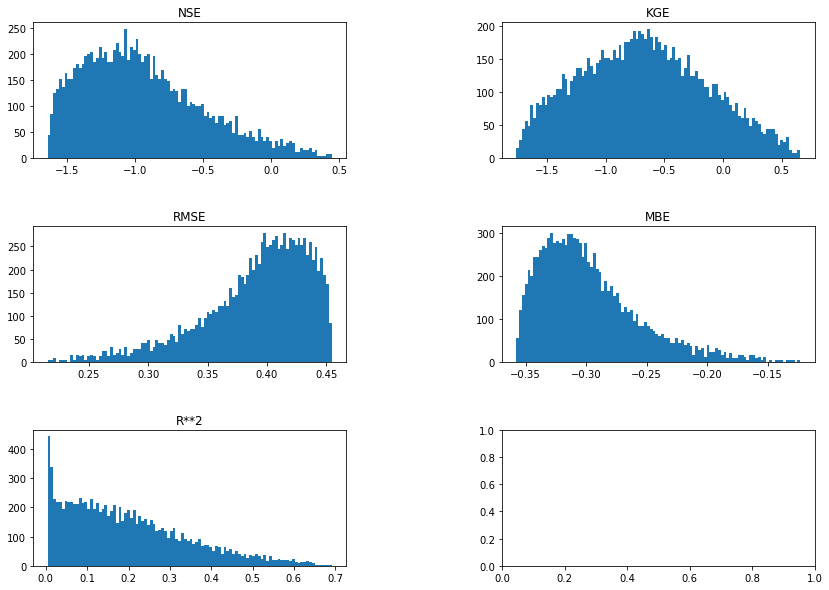

In [43]:
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs[0, 0].hist(dataav['NSE'],bins=100)
axs[0, 0].set_title('NSE')
axs[0, 1].hist(dataav['KGE'],bins=100)
axs[0, 1].set_title('KGE')
axs[1, 0].hist(dataav['RMSE'],bins=100)
axs[1, 0].set_title('RMSE')
axs[1, 1].hist(dataav['MBE'],bins=100)
axs[1, 1].set_title('MBE')
axs[2, 0].hist(dataav['R_2'],bins=100)
axs[2, 0].set_title('R**2')

In [29]:
#fig.savefig(figpath+'domain_cal_metrics_averaged.pdf', format='pdf', dpi=300)

In [44]:
def get_top_idx(metric):
    if (metric == 'R_2') | (metric == 'NSE')|(metric == 'KGE'):
        x = dataav[metric].values
        index = np.where(x==np.max(x))
    elif (metric == 'MBE'):
        x = np.abs(dataav['MBE']).values
        index = np.where(x==np.min(x))
    elif (metric == 'RMSE'):
        x = dataav[metric]
        index = np.where(x==np.min(x))
    return index[0][0]


top_params = []
top_params.append(get_top_idx('NSE'))
top_params.append(get_top_idx('KGE'))
top_params.append(get_top_idx('MBE'))
top_params.append(get_top_idx('RMSE'))
top_params.append(get_top_idx('R_2'))
top_params

[8052, 8052, 8052, 8052, 8052]

In [45]:
#the parameters for the top performing runs
topav = calibration.iloc[top_params]
topav = topav.reset_index(drop=True)
topav

,lat_solar_flag,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust,gap_frac
0,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.0
1,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.0
2,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.0
3,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.0
4,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.0


## Re-run SM with optimal configurations identified above

In [55]:
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
compileFile = SMpath+'code/compile_snowmodel.script'
ctlFile = SMpath+'ctl_files/wo_assim/swed.ctl'
sweFile = SMpath+'outputs/wo_assim/swed.gdat'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'

In [46]:
#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()

In [47]:
with open('par_base.json') as f:
    base = json.load(f)
    
for key in base:
    edit_par(base,key,base[key][0])
    
#edit snowmodel.par
edit_par(base,'nx',np.shape(gdf)[0])
edit_par(base,'ny',1)
edit_par(base,'xmn',domains[domain]['xll'])
edit_par(base,'ymn',domains[domain]['yll'])
edit_par(base,'dt',21600) 
edit_par(base,'iyear_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').year)
edit_par(base,'imonth_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').month)
edit_par(base,'iday_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').day)
edit_par(base,'xhour_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').hour)
edit_par(base,'max_iter',(datetime.strptime(domains[domain]['ed'],'%Y-%m-%d')-
    datetime.strptime(domains[domain]['st'],'%Y-%m-%d')).days*4+4)
edit_par(base,'met_input_fname','../CSOdmn/'+domain+'/mm_'+domain+'_2014-2019.dat')
edit_par(base,'ascii_topoveg',1)
edit_par(base,'topo_ascii_fname','../CSOdmn/'+domain+'/DEM_'+domain+'.asc')
edit_par(base,'veg_ascii_fname','../CSOdmn/'+domain+'/NLCD2016_'+domain+'.asc')
edit_par(base,'xlat',40.2)
edit_par(base,'run_snowtran',0)
edit_par(base,'barnes_lg_domain',1)
edit_par(base,'snowmodel_line_flag',1)
edit_par(base,'lapse_rate','.28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87')#
edit_par(base,'prec_lapse_rate','0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.32,0.43,0.39')#
edit_par(base,'print_inc',4)
edit_par(base,'print_var_01','y')
edit_par(base,'print_var_09','y')
edit_par(base,'print_var_10','y')
edit_par(base,'print_var_11','y')
edit_par(base,'print_var_12','y')
edit_par(base,'print_var_14','y')
edit_par(base,'print_var_18','y')
edit_par(base,'snowfall_frac',3)
edit_par(base,'cf_precip_flag',3)

In [48]:
num_sim_days = (datetime.strptime(domains[domain]['ed'],'%Y-%m-%d')-
                datetime.strptime(domains[domain]['st'],'%Y-%m-%d')).days+1
def get_mod_output_line(inFile):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_sim_days,1,np.shape(gdf)[0]))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,:]) 

    return data

In [49]:
%%time
%cd $SMpath

top_swe = np.empty([len(top_params),num_sim_days,np.shape(gdf)[0]])
for i in range(len(top_params)):
    edit_par(base,'lat_solar_flag',calibration.lat_solar_flag[top_params[i]])
    edit_par(base,'lapse_rate',calibration.lapse_rate[top_params[i]])
    edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate[top_params[i]])
    edit_par(base,'ro_snowmax',calibration.ro_snowmax[top_params[i]])
    edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar[top_params[i]])
    edit_par(base,'ro_adjust',calibration.ro_adjust[top_params[i]]) 
    ! nohup ./snowmodel
    mod_swe = get_mod_output_line(sweFile)
    top_swe[i,:,:] = mod_swe

%cd $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill2
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
CPU times: user 30 ms, sys: 51.1 ms, total: 81.1 ms
Wall time: 18.2 s


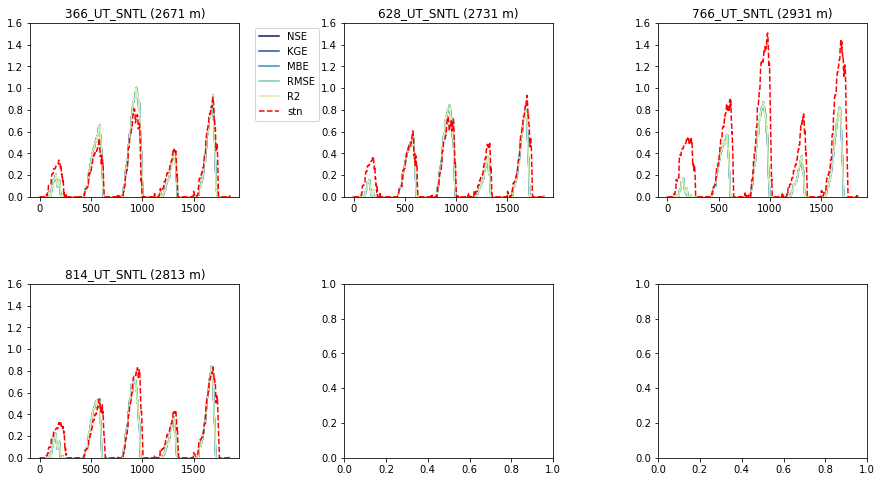

In [50]:
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm



n=np.shape(top_swe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=2, figsize=(15, 8), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = np.squeeze(top_swe[:,:,i])
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    for j in range(n):
        c=next(color)
        axs[i].plot(np.transpose(mod[j,:]),c=c)
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['NSE', 'KGE', 'MBE','RMSE','R2','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [46]:
fig.savefig(figpath+'SWE_top_calmetrics_2020-07_06_av.pdf', format='pdf', dpi=300)

# Top ranked score

-> each OF is ranked independently

-> the rank scores are summed across each model run 

-> The summed scores are then ranked and the top scores are used to identify the top model parameter combinations

In [51]:
dataav['NSE_rank']=dataav['NSE'].rank(ascending=False)
dataav['KGE_rank']=dataav['KGE'].rank(ascending=False)
dataav['R_2_rank']=dataav['R_2'].rank(ascending=False)
dataav['RMSE_rank']=dataav['RMSE'].rank()
dataav['MBE_rank']=np.abs(dataav['MBE']).rank()
dataav['score']=dataav['NSE_rank']+ dataav['KGE_rank']+dataav['R_2_rank']+ dataav['RMSE_rank']+dataav['MBE_rank']
dataav['score_rank'] = dataav['score'].rank()
dataav.head()

,NSE,KGE,RMSE,R_2,MBE,NSE_rank,KGE_rank,R_2_rank,RMSE_rank,MBE_rank,score,score_rank
0,-1.464497,-1.420413,0.440238,0.026080,-0.341565,9674.5,9778.5,9686.5,9666.5,9594.5,48400.5,9686.5
1,-1.464497,-1.420413,0.440238,0.026080,-0.341565,9674.5,9778.5,9686.5,9666.5,9594.5,48400.5,9686.5
2,-1.464497,-1.420413,0.440238,0.026080,-0.341565,9674.5,9778.5,9686.5,9666.5,9594.5,48400.5,9686.5
3,-1.464497,-1.420413,0.440238,0.026080,-0.341565,9674.5,9778.5,9686.5,9666.5,9594.5,48400.5,9686.5
4,-1.476788,-1.445666,0.441250,0.023267,-0.342544,9766.5,9886.5,9774.5,9754.5,9706.5,48888.5,9794.5


In [52]:
rank_params = np.where((dataav['score_rank']==min(dataav['score_rank'])))
top_params = rank_params[0]
label = dataav['score_rank'][top_params].values
top_params

array([8052, 8053, 8054, 8055])

In [49]:
#the parameters for the top performing runs
toprank = calibration.iloc[top_params]
#toprank = dataav.iloc[top_params]
toprank

,lat_solar_flag,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust,gap_frac
8052,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.0
8053,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.2
8054,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.4
8055,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",725.0,1.3,4.0,0.6


In [50]:
%%time
%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill2/

top_swe = np.empty([len(top_params),num_sim_days,np.shape(gdf)[0]])
for i in range(len(top_params)):
    edit_par(base,'lat_solar_flag',calibration.lat_solar_flag[top_params[i]])
    edit_par(base,'lapse_rate',calibration.lapse_rate[top_params[i]])
    edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate[top_params[i]])
    edit_par(base,'ro_snowmax',calibration.ro_snowmax[top_params[i]])
    edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar[top_params[i]])
    edit_par(base,'ro_adjust',calibration.ro_adjust[top_params[i]]) 
    ! nohup ./snowmodel
    mod_swe = get_mod_output_line(sweFile)
    top_swe[i,:,:] = mod_swe

%cd  /nfs/attic/dfh/Aragon2/Notebooks/calibration_python

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill2
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
CPU times: user 35.7 ms, sys: 63.5 ms, total: 99.3 ms
Wall time: 15.6 s


In [27]:
# #this worked with a smaller calibration parameter set but does not work if their are ties for first place rankings
# rank_params = np.where((dataav['score_rank']==1)|(dataav['score_rank']==2)|(dataav['score_rank']==3))

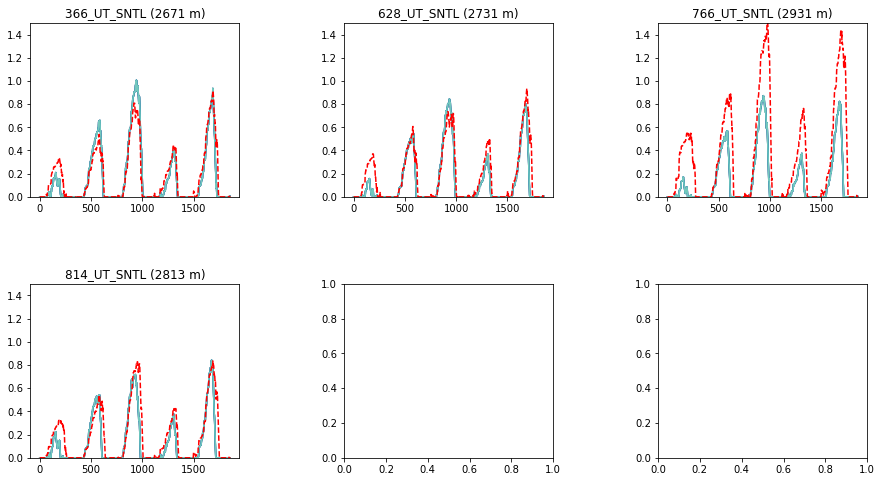

In [52]:
#Ranking plot WY
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(top_swe)[0]

# label =[]
# label.append(dataav.iloc[top_params]['score_rank'])
# label

fig, axs = plt.subplots(nrows=2, figsize=(15, 8), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = np.squeeze(top_swe[:,:,i])
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+2)))
    for j in range(n):
        c=next(color)
        axs[i].plot(np.transpose(mod[j,:]),c=c)
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 1.5])
#     if i == 0:
#         axs[i].legend([str(label[0]),str(label[1]),str(label[2]),'stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

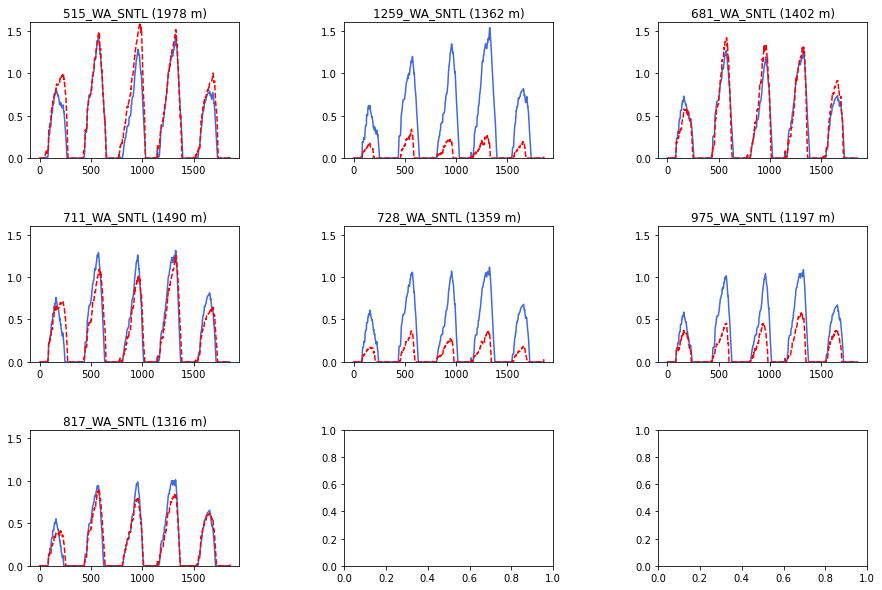

In [99]:
#Ranking plot OR -> one winning rank score 
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(top_swe)[0]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = np.squeeze(top_swe[:,:,i])
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+2)))
    axs[i].plot(mod,c='royalblue')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 1.6])
#     if i == 0:
#         axs[i].legend([str(label[0]),str(label[1]),str(label[2]),'stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [53]:
fig.savefig(figpath+'SWE_top_calmetrics_2020-07_06_rank.pdf', format='pdf', dpi=300)

# Initiate full run of SM based on above findings

In [53]:
#the parameters for the top performing runs
calibration.loc[get_top_idx('KGE')]

lat_solar_flag                                                      1
lapse_rate            4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7
prec_lapse_rate     0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...
ro_snowmax                                                        725
cf_precip_scalar                                                  1.3
ro_adjust                                                           4
gap_frac                                                            0
Name: 8052, dtype: object

In [59]:
# need to discuss how to choose the top - currently set up to analyze based on OF

OF = 'KGE'

#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+domains[domain]['ncols']+',ny_max='+domains[domain]['nrows']+')\n')#full domain

#remove line flag
edit_par(base,'snowmodel_line_flag',0)
edit_par(base,'nx',domains[domain]['ncols'])
edit_par(base,'ny',domains[domain]['nrows'])
edit_par(base,'lat_solar_flag',calibration.lat_solar_flag.loc[get_top_idx(OF)])
edit_par(base,'lapse_rate',calibration.lapse_rate.loc[get_top_idx(OF)])
edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate.loc[get_top_idx(OF)])
edit_par(base,'ro_snowmax',calibration.ro_snowmax.loc[get_top_idx(OF)])
edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar.loc[get_top_idx(OF)])
edit_par(base,'ro_adjust',calibration.ro_adjust.loc[get_top_idx(OF)])  
    
#run compile script 
#Compile SnowModel

%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/code/
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [ ]:
# in command line - initiate the full model run
# $ cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/
# $ ! nohup ./snowmodel

# Find top performing calibration combinations
This is looking at individual stations for individual calibration runs

In [ ]:
NSE = data.cal_metrics.loc[:,"NSE",:]
nse_top = np.amax(data.cal_metrics.loc[:,"NSE",:],axis = 0)
KGE = data.cal_metrics.loc[:,"KGE",:]
kge_top = np.amax(data.cal_metrics.loc[:,"KGE",:],axis = 0)
RMSE = data.cal_metrics.loc[:,"RMSE",:]
rmse_top = np.amin(data.cal_metrics.loc[:,"RMSE",:],axis = 0)
MAE = data.cal_metrics.loc[:,"MAE",:]
mae_top = np.amin(data.cal_metrics.loc[:,"MAE",:],axis = 0)
MBE = data.cal_metrics.loc[:,"MBE",:]
mbe_top = np.amin(data.cal_metrics.loc[:,"MBE",:],axis = 0)

In [ ]:
NSE = data.cal_metrics.loc[:,"NSE",:].values
KGE = data.cal_metrics.loc[:,"KGE",:].values
RMSE = data.cal_metrics.loc[:,"RMSE",:].values
MAE = data.cal_metrics.loc[:,"MAE",:].values
MBE = data.cal_metrics.loc[:,"MBE",:].values

In [ ]:
#plot distribution of calibration metrics 

fig, axs = plt.subplots(1, 3,figsize=(14, 8))
axs[0].hist(NSE,label = 'NSE',align='mid',edgecolor='black')
axs[0].legend()
axs[1].hist(KGE,label = 'KGE',align='mid',edgecolor='black')
axs[1].legend()
axs[2].hist(RMSE,label = 'RMSE',align='mid',edgecolor='black')
axs[2].legend()